In [56]:
using SparseArrays
using Arpack
using LinearAlgebra
using Plots

In [2]:
# 2D CCW rotation of v by theta
function rot(theta, v)
    R = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    return R * v
end

rot (generic function with 1 method)

In [3]:
function f(k, a)
    s = 0
    vec = [0; a/sqrt(3)]
    for n in 0:2
        delta = rot(n * 2*pi / 3, vec)
        s += exp(dot(k, delta)im)
    end
    return s
end

f (generic function with 1 method)

In [4]:
function uAB(uD, Nl, l)
    return uD * (l + 1 - (1/2) * (Nl - 1))
end

uAB (generic function with 1 method)

In [13]:
function h0(uD, Nl, l, t0, a, k)
    uA = uAB(uD, Nl, l)
    uB = uAB(uD, Nl, l)
    h0 = zeros(ComplexF64, 2, 2)
    h0[1, 1] = uA
    h0[2, 2] = uB
    h0[1, 2] = -t0 * f(k, a)
    h0[2, 1] = -t0 * conj(f(k, a))
    return h0
end

h0 (generic function with 1 method)

In [14]:
function h1(t1, t3, t4, a, k)
    h1 = zeros(ComplexF64, 2, 2)
    h1[1, 1] = t4 * f(k, a)
    h1[1, 2] = t3 * conj(f(k, a))
    h1[2, 1] = t1
    h1[2, 2] = t4 * f(k, a)
    return h1
end

h1 (generic function with 1 method)

In [18]:
function h2(t2)
    h2 = zeros(ComplexF64, 2, 2)
    h2[1,2] = t2/2
    return h2
end

h2 (generic function with 1 method)

In [178]:
function hRG(a, uD, t0, t1, t2, t3, t4, Nl, k)
    ham0 = zeros(2 * Nl, 2 * Nl)
    for l in 1:Nl
        temp = zeros(Nl, Nl)
        temp[l, l] = 1
        ham0 += kron(h0(uD, Nl, l, t0, a, k), temp)
    end
    utri1 = zeros(Nl, Nl)
    for i in 2:Nl
        utri1[i - 1, i] = 1
    end
    ham1 = kron(h1(t1, t3, t4, a, k), utri1) + adjoint(kron(h1(t1, t3, t4, a, k), utri1))
    utri2 = zeros(Nl, Nl)
    for i in 3:Nl
        utri1[i - 2, i] = 1
    end
    ham2 = kron(h2(t2), utri2) + adjoint(kron(h2(t2), utri2))
    return ham0 + ham1 + ham2
end

hRG (generic function with 1 method)

In [212]:
a = 2.46
uD = 0
t0 = 3.1
t1 = 0.38
t2 = -0.21
t3 = 0.29
t4 = 0.141
Nl = 3
nvals = 2 * Nl
samps = 1000
k_range = range(-4*pi/a, 4*pi/a, samps)
eigenvals = Array{Float64}(undef, samps, samps, nvals)
for i in 1:samps
    for j in 1:samps
        kx = k_range[i]
        ky = k_range[j]
        ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx; ky])
        vals = eigvals(ham)
        for p in 1:nvals
            eigenvals[i, j, p] = real(vals[p])
        end
    end
end

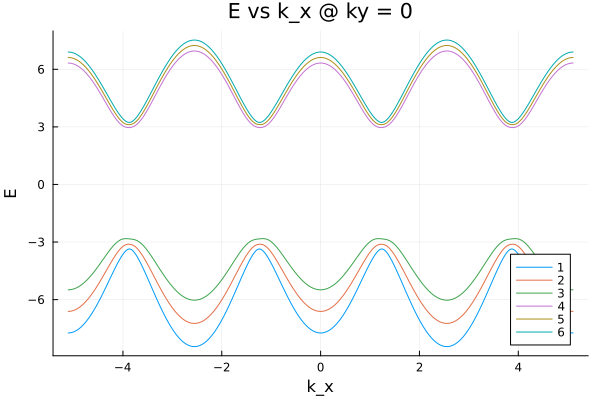

In [213]:
P = plot()
plot!(P, title = "E vs k_x @ ky = 0", xlabel = "k_x", ylabel = "E")
for i in 1:nvals
    plot!(k_range, eigenvals[:, 1, i], label = string(i))
end
display(P)

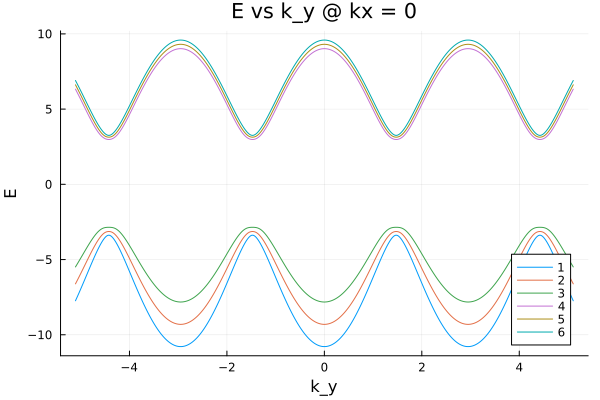

In [214]:
P = plot()
plot!(P, title = "E vs k_y @ kx = 0", xlabel = "k_y", ylabel = "E")
for i in 1:nvals
    plot!(k_range, eigenvals[1, :, i], label = string(i))
end
display(P)

In [215]:
G1 = [2*pi/a; -2*pi/(sqrt(3) * a)]
G2 = [0; 2*pi/a * 2/sqrt(3)]
K = (2/3) * G1 + (1/3) * G2
Kp = (1/3) * G1 + (2/3) * G2

2-element Vector{Float64}:
 0.8513801229240632
 1.4746336294587135

In [216]:
K_eigenvals = Array{Float64}(undef, samps, nvals)
for i in 1:samps
    kx = k_range[i]
    ky = K[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx; ky])
    vals = eigvals(ham)
    for p in 1:nvals
        K_eigenvals[i, p] = real(vals[p])
    end
end

Kp_eigenvals = Array{Float64}(undef, samps, nvals)
for i in 1:samps
    kx = k_range[i]
    ky = Kp[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx; ky])
    vals = eigvals(ham)
    for p in 1:nvals
        Kp_eigenvals[i, p] = real(vals[p])
    end
end

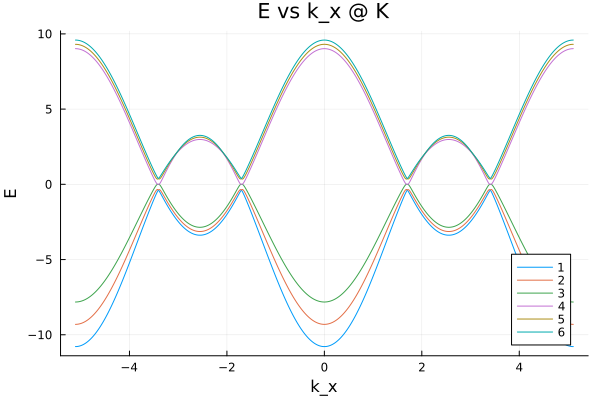

In [217]:
P = plot()
plot!(P, title = "E vs k_x @ K", xlabel = "k_x", ylabel = "E")
for i in 1:nvals
    plot!(k_range, K_eigenvals[:, i], label = string(i))
end
display(P)

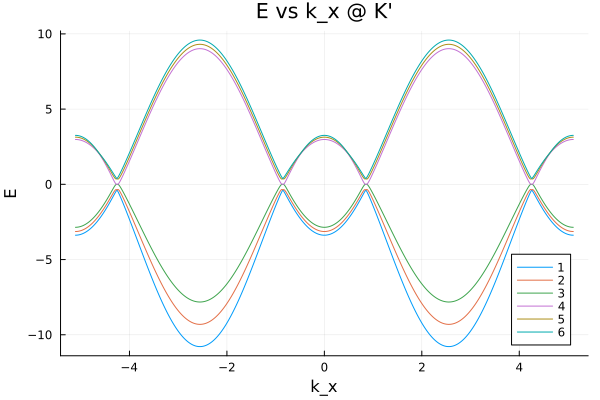

In [218]:
P = plot()
plot!(P, title = "E vs k_x @ K'", xlabel = "k_x", ylabel = "E")
for i in 1:nvals
    plot!(k_range, Kp_eigenvals[:, i], label = string(i))
end
display(P)